Shape of data:  (1000, 2, 512, 512)
[0. 1.]


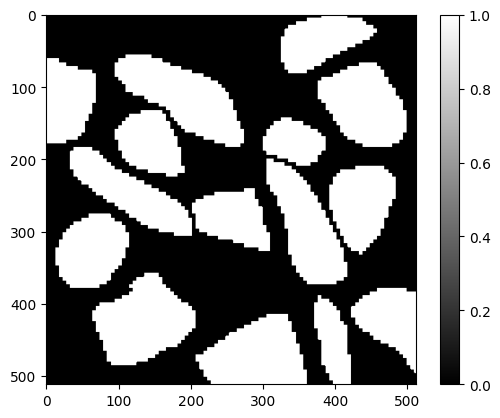

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
data = np.load("combined_patches.npy",allow_pickle=True)
data = np.array(data,dtype=np.float32)
data = np.random.permutation(data)
print("Shape of data: ", data.shape)
print(np.unique(data))

plt.imshow(data[0][1],cmap="gray",vmin=0,vmax=1)
plt.colorbar()
plt.show()

In [2]:
train_size, val_size = 800, 150
train_data, val_data, test_data = np.split(data, [train_size, train_size+val_size])
print("Shape of train_data: ", train_data.shape)
print("Shape of val_data: ", val_data.shape)
print("Shape of test_data: ", test_data.shape)

Shape of train_data:  (800, 2, 512, 512)
Shape of val_data:  (150, 2, 512, 512)
Shape of test_data:  (50, 2, 512, 512)


In [3]:
from dataset import SheetletCellDataset
from torchvision import transforms

transform = transforms.Compose([
        #transforms.Pad(padding=20,padding_mode="reflect"),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10,fill=0),
        #transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.15), shear=2),    
    ])

train_dataset = SheetletCellDataset(train_data, transform=transform)
val_dataset = SheetletCellDataset(val_data)
test_dataset = SheetletCellDataset(test_data)

for i in range(len(train_dataset)):
    print(train_dataset[i][0].shape,train_dataset[i][1].shape)
    break

torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=4,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=12, shuffle=True, num_workers=4,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=True, num_workers=4,pin_memory=True)

#get first batch
batch = next(iter(train_dataloader))
print(batch[0].shape,batch[1].shape)


torch.Size([12, 1, 512, 512]) torch.Size([12, 1, 512, 512])


In [ ]:
from model import GANModel
from utils import load_config

config = load_config("config.yaml")
model = GANModel(config, lr=0.000005)



/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model

GANModel(
  (generator): Generator(
    (encoder): Encoder(
      (encoder_blocks): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
        (1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
        (2): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
        (3): Sequential(
          (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReL

In [7]:
from pytorch_lightning.loggers import WandbLogger  # Change thisfrom 
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torch
wandb_logger = WandbLogger(
        project="sheetlet-gan",
        name="gan-training",
        log_model=True,
        config=config)
    
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="gan-{epoch:02d}-{val_g_loss:.2f}",
        save_top_k=3,
        mode="min")

In [8]:
trainer = pl.Trainer(
        max_epochs=500,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=[1],
        logger=wandb_logger,  # Use wandb logger
        callbacks=[checkpoint_callback],
        log_every_n_steps=10,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: ignasialemanyjuv (ignasialemanyjuv-imperial-college-london). Use `wandb login --relogin` to force relogin


/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ignasi/Desktop/StyleGAN/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | generator        | Generator         | 23.6 M | train
1 | discriminator    | Discriminator     | 2.8 M  | train
2 | adversarial_loss | BCEWithLogitsLoss | 0      | train
3 | l1_loss          | L1Loss            | 0      | train
---------------------------------------------------------------
26.4 M    Trainable params
0         Non-trainable params
26.4 M    Total params
105.545   Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 19: 100%|██████████| 67/67 [00:18<00:00,  3.71it/s, v_num=drue, g_loss_l1=0.401, val_loss=0.396]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb88d1eb2e0>
Traceback (most recent call last):
  File "/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/

Epoch 20:  52%|█████▏    | 35/67 [00:09<00:08,  3.70it/s, v_num=drue, g_loss_l1=0.371, val_loss=0.396]